1. Project Title & Team Information

Title:  Accident Risk Analysis: Urban vs. Rural Populations

Team Members: Dave Woodford, Tim Mai, Matt Dolin, and Phillip Roman

#TO DO: Team Members Table (Name, Role, Skills, Contribution)

2. Project Definition & Motivation

Objective: "Does accident frequency increase in high-population counties? Do factors differ between rural and metro areas?"

Stakeholders: Dept of Transporation, Railroad Administration, Railroad companies, local municipaliteis, and the public

Potential Application: A risk-assessment tool or "safe travel" dashboard


# 3. Data Sources & Selection

To investigate the relationship between population density and rail safety, we selected two primary datasets that allow for a granular geospatial analysis at the county level.

### **Source A: Rail Equipment Accident/Incident Data (Form 54)**
* **Publisher:** Federal Railroad Administration (FRA) / Department of Transportation (DOT)
* **Period:** 2012 - Present (Filtered for schema consistency)
* **URL:** [DOT Open Data Portal](https://data.transportation.gov/Railroads/Rail-Equipment-Accident-Incident-Data-Form-54-/85tf-25kj/about_data)
* **Justification & Selection Criteria:**
    * **Authoritative Record:** This dataset is the federal standard for reportable rail accidents.
    * **Reporting Threshold:** We acknowledge that this dataset excludes minor incidents. Inclusion is based on a monetary reporting threshold (adjusted annually for inflation, approx. $12,000+ in recent years), ensuring our analysis focuses on events with significant economic impact or infrastructure damage.
    * **Temporal Cut-off:** We restricted our analysis to data starting from **2012**. While the FRA updated their reporting schema in June 2011, we excluded the entire transition year to ensure maximum data integrity and consistent definitions for key variables like `TERRITORY`.

### **Source B: Rural-Urban Continuum Codes (2023)**
* **Publisher:** USDA Economic Research Service (ERS)
* **Period:** 2023 Edition
* **URL:** [USDA ERS Data Products](https://www.ers.usda.gov/data-products/rural-urban-continuum-codes)
* **Justification (USDA vs. US Census):**
    * **Superior Granularity:** Standard US Census data relies on simple population counts. The USDA RUCC system classifies counties into a 9-point scale based on distinct *environmental* factors.
    * **The "Adjacency" Factor:** Crucially, this dataset distinguishes rural counties by their **adjacency to metropolitan areas**. This is vital for our analysis, as we hypothesize that rural counties adjacent to major transit hubs face different rail traffic risks than isolated rural counties—a nuance that standard census counts would miss.

In [13]:
# Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

# Load data
rail_accident_path = "../data/raw/Rail_Equipment_Accident_Incident_Data_(Form_54)_20260114.csv.zip"
population_path = "../data/raw/Ruralurbancontinuumcodes2023.csv"

df_accident_all = pd.read_csv(
    rail_accident_path,
    low_memory=False
)

df_population = pd.read_csv(
    population_path,
    encoding="latin1"
)

# Checks
print(f"Rail Data Loaded. Shape: {df_accident_all.shape}")
print(f"Population Data Loaded. Shape: {df_population.shape}")
print()
display(df_accident_all.head(3))
print()
display(df_population.head(3))

Rail Data Loaded. Shape: (223529, 155)
Population Data Loaded. Shape: (9703, 5)



,Reporting Railroad Code,Reporting Railroad Name,Year,Accident Number,PDF Link,Accident Year,Accident Month,Other Railroad Code,Other Railroad Name,Other Accident Number,...,Reporting Parent Railroad Name,Reporting Railroad Holding Company,Reporting Railroad Individual Class,Reporting Railroad Passenger,Reporting Railroad Commuter,Reporting Railroad Switching Terminal,Reporting Railroad Tourist,Reporting Railroad Freight,Reporting Railroad Short Line,Location
0,SOO,SOO Line Railroad Company,1981,CA28,https://safetydata.fra.dot.gov/Officeofsafety/...,81,8,NaN,NaN,NaN,...,CANADIAN PACIFIC KANSAS CITY,Not Assigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,NaN
1,MP,Missouri Pacific Railroad Company,1981,81230,https://safetydata.fra.dot.gov/Officeofsafety/...,81,9,NaN,NaN,NaN,...,Union Pacific Railroad Company,Union Pacific Railroad Company,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,NaN
2,SP,Southern Pacific Transportation Company,1980,W1200,https://safetydata.fra.dot.gov/Officeofsafety/...,80,1,NaN,NaN,NaN,...,Union Pacific Railroad Company,Union Pacific Railroad Company,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,NaN


,FIPS,State,County_Name,Attribute,Value
0,1001,AL,Autauga County,Population_2020,58805
1,1001,AL,Autauga County,RUCC_2023,2
2,1001,AL,Autauga County,Description,"Metro - Counties in metro areas of 250,000 to ..."


# 4. Methodology: Data Ingestion & Cleaning

Our analysis requires merging two disparate datasets that lack a common unique identifier in their raw state. The Rail Accident data uses separate columns for "State" and "County," while the Census data uses a unified 5-digit FIPS code.

**Data Cleaning Pipeline:**
1.  **Temporal Filtering:** We filtered the dataset to include only years **> 2011**, avoiding the schema inconsistencies of the pre-2011 reporting standards.
2.  **Null Removal:** Rows with missing "County Code" identifiers were removed to ensure accurate geospatial mapping, as these records cannot be linked to census data.
3.  **FIPS Construction:** We synthesized a 5-digit Federal Information Processing Standard (FIPS) code for the rail data by padding the State Code (2 digits) and County Code (3 digits).
4.  **Pivoting:** The Census data was pivoted from a "Long" format (multiple rows per county) to a "Wide" format (one row per county) to expose `Population_2020` and `Description` as distinct columns.

In [22]:
df_accident = df_accident_all.copy()

# Filter for accidents after 2011
df_accident = df_accident[df_accident["Year"] > 2011]

# Clean railroad accident data
df_accident = df_accident.dropna(subset=["County Code"])
df_accident["State Code FIPS"] = df_accident["State Code"].astype(int).astype(str).str.zfill(2)
df_accident["County Code FIPS"] = df_accident["County Code"].astype(int).astype(str).str.zfill(3)
df_accident["FIPS"] = (df_accident["State Code FIPS"] + df_accident["County Code FIPS"]).astype(int)

# Clean population data
df_population_wide = df_population.pivot(index="FIPS", columns="Attribute", values="Value").reset_index()
df_population_wide["FIPS"] = df_population_wide["FIPS"].astype(int)
df_population_wide.columns.name = None

# Verify population is numeric - remove if not
if "Population_2020" in df_population_wide.columns:
    df_population_wide["Population_2020"] = (
        pd.to_numeric(df_population_wide["Population_2020"].astype(str).str.replace(",", ""), errors="coerce")
    )

# Checks
print("Railroad Data: FIPS Check")
cols_to_verify = ["State Code", "County Code", "State Code FIPS", "County Code FIPS", "FIPS"]
display(df_accident[cols_to_verify].head())

print("\nPopulation Data: Pivot Check - wide")
display(df_population_wide.head())


Railroad Data: FIPS Check


,State Code,County Code,State Code FIPS,County Code FIPS,FIPS
50,53,53.0,53,053,53053
54,21,15.0,21,015,21015
56,47,37.0,47,037,47037
58,45,47.0,45,047,45047
1159,12,99.0,12,099,12099



Population Data: Pivot Check - wide


,FIPS,Description,Population_2020,RUCC_2023
0,1001,"Metro - Counties in metro areas of 250,000 to ...",58805,2
1,1003,Metro - Counties in metro areas of fewer than ...,231767,3
2,1005,"Nonmetro - Urban population of 5,000 to 20,000...",25223,6
3,1007,Metro - Counties in metro areas of 1 million p...,22293,1
4,1009,Metro - Counties in metro areas of 1 million p...,59134,1


### **5. The Merge Strategy**

We merged the Rail Accident data with the Census data using a **Left Join** on the generated `FIPS` key.

* **Linkage:** Accidents were matched to their corresponding county population and rural-urban classification.
* **Exclusion of Unmatched Records:** Following the merge, we removed any accident records that failed to match with a valid census entry (i.e., where `Population_2020` was null). This step is necessary because accidents occurring in unidentified counties cannot be normalized for follow-on per-capita risk analysis.

In [21]:
# Merge
df_merged = pd.merge(
    df_accident,
    df_population_wide,
    on="FIPS",
    how="left"
)

# Drop rows/accidents where population is blank
df_merged = df_merged.dropna(subset=["Population_2020"])

# Checks
print(f"Merged Shape: {df_merged.shape}")
print("New columns available:", list(df_population_wide.columns))
cols_to_show = ["FIPS", "State Name", "Description", "Population_2020"]
display(df_merged[cols_to_show].head())

Merged Shape: (34562, 161)
New columns available: ['FIPS', 'Description', 'Population_2020', 'RUCC_2023']


,FIPS,State Name,Description,Population_2020
0,53053,WASHINGTON,Metro - Counties in metro areas of 1 million p...,921130.0
1,21015,KENTUCKY,Metro - Counties in metro areas of 1 million p...,135968.0
2,47037,TENNESSEE,Metro - Counties in metro areas of 1 million p...,715884.0
3,45047,SOUTH CAROLINA,"Nonmetro - Urban population of 20,000 or more,...",69351.0
4,12099,FLORIDA,Metro - Counties in metro areas of 1 million p...,1492191.0


6. Initial Exploratory Analysis (EDA)

The Question: "Is there a correlation between population size and raw accident count?"

The Visualization: Your scatter plot (plt.scatter(x,y)).

The Caption/Interpretation: "The plot shows a positive correlation (0.58), but outliers exist. This suggests that while population is a factor, other variables (track density, traffic volume) likely play a role."

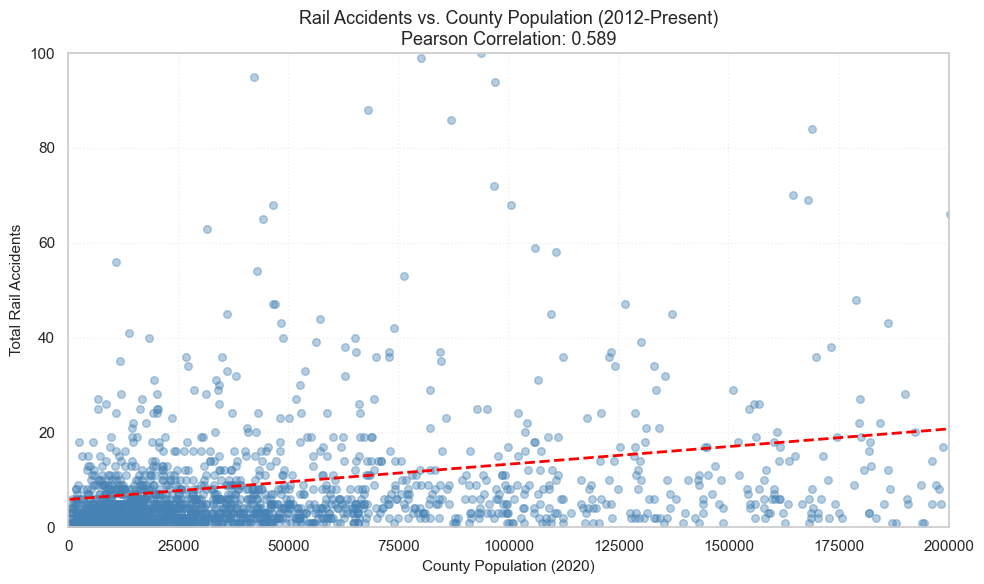

As expected, there's a positive correlation (r = 0.589) between
population and accident volume. However, this surface-level view doesn't
account for risk per capita - our next analysis.


In [ ]:
# Initial EDA
# Correlation population vs accident volume


county_stats = df_merged.groupby("FIPS").agg({
    "Population_2020": "first",
    "Description": "first"
})
county_stats["Total_Accidents"] = df_merged.groupby("FIPS").size()

# Calculate correlation
correlation = county_stats["Total_Accidents"].corr(county_stats["Population_2020"])

# Scatterplot 
plt.figure(figsize=(10, 6))

plt.scatter(
    county_stats["Population_2020"], 
    county_stats["Total_Accidents"],
    alpha=0.4,
    s=30,
    color='steelblue'
)

# Regression line
sns.regplot(
    data=county_stats, 
    x="Population_2020", 
    y="Total_Accidents", 
    scatter=False, 
    color="red",
    ci=None,
    line_kws={"linestyle": "--", "linewidth": 2}
)

plt.xlim(0, 200000)
plt.ylim(0, 100)
plt.title(f"Rail Accidents vs. County Population (2012-Present)\nPearson Correlation: {correlation:.3f}", 
          fontsize=13)
plt.xlabel("County Population (2020)", fontsize=11)
plt.ylabel("Total Rail Accidents", fontsize=11)
plt.grid(True, alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

# Thoughts
print(f"As expected, there's a positive correlation (r = {correlation:.3f}) between")
print(f"population and accident volume. However, this surface-level view doesn't")
print(f"account for risk per capita - our next analysis.")


### **Initial Findings: Volume vs. Risk**

**1. The Volume View (Baseline)**
The scatterplot above examines counties with populations under 200,000—where the vast majority of U.S. counties fall. Even within this focused range, we observe a moderate positive correlation (**r = 0.59**) between county population and total accident count. This confirms our initial hypothesis: more people and rail activity generally lead to more accidents in absolute terms.

**2. The Risk View (The Pivot)**
However, raw accident counts don't tell the full story. When we normalize by population to calculate *risk intensity* (accidents per 100,000 residents), the pattern reverses dramatically. The bar chart below reveals that smaller, rural counties—especially those isolated from metropolitan areas—face significantly higher per-capita accident rates than their urban counterparts.

PLACEHOLDER FOR MARKDOWN FOR BELOW CHART
    Initial EDA: Urban Volume vs Rural Risk
    Calculating Accidents per 100k Residents

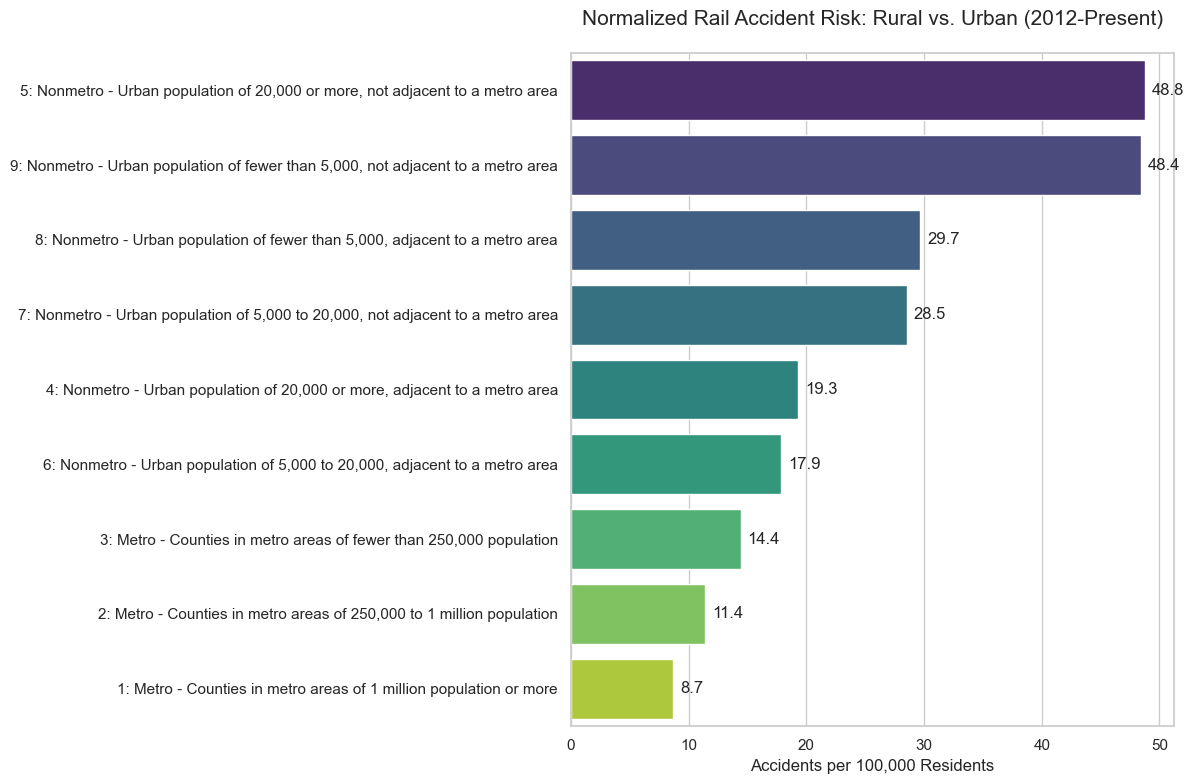

Risk Analysis Table (Verified with RUCC Codes):


,Code,USDA_Category,Total Accidents,Accidents_Per_100k
0,5,"Nonmetro - Urban population of 20,000 or more,...",1540,48.794939
1,9,"Nonmetro - Urban population of fewer than 5,00...",1096,48.423219
2,8,"Nonmetro - Urban population of fewer than 5,00...",1033,29.674665
3,7,"Nonmetro - Urban population of 5,000 to 20,000...",1228,28.532328
4,4,"Nonmetro - Urban population of 20,000 or more,...",2022,19.307607
5,6,"Nonmetro - Urban population of 5,000 to 20,000...",1450,17.870825
6,3,Metro - Counties in metro areas of fewer than ...,3630,14.403711
7,2,"Metro - Counties in metro areas of 250,000 to ...",6962,11.411086
8,1,Metro - Counties in metro areas of 1 million p...,15601,8.687817


In [ ]:
# Initial EDA: Urban Volume vs Rural Risk
# Calculating Accidents per 100k Residents

# Numerator - Count total accidents by USDA Category
accidents_by_cat = df_merged["Description"].value_counts()

# Denominator - Sum TOTAL population by USDA Category
# we drop duplicates so we don't doublecount the population of the same county 
# for every accident that happened there
df_unique_counties = df_merged.drop_duplicates(subset=["FIPS"])
population_by_cat = df_unique_counties.groupby("Description")["Population_2020"].sum()

# Risk ratio (Accidents / Population) * 100,000
df_risk = pd.DataFrame({
    "Total Accidents": accidents_by_cat,
    "Total Population": population_by_cat
})

df_risk["Accidents_Per_100k"] = (df_risk["Total Accidents"] / df_risk["Total Population"]) * 100000
df_risk = df_risk.sort_values("Accidents_Per_100k", ascending=False).reset_index()
df_risk.rename(columns={"Description": "USDA_Category"}, inplace=True)

# Add RUCC codes to labels
def get_rucc_code(desc):
    desc = desc.lower()
    # Metro checks (1-3)
    # Check "250k to 1 mil" first to avoid false match on 1 million
    if "250,000 to 1 million" in desc: return 2
    if "1 million" in desc: return 1
    if "fewer than 250,000" in desc: return 3
    
    # Non-metro checks (4-9)
    if "20,000 or more" in desc:
        if "not adjacent" in desc: return 5
        return 4
        
    # "5,000 to 20,000" for Codes 6/7
    if "5,000 to 20,000" in desc or "2,500 to 19,999" in desc:
        if "not adjacent" in desc: return 7
        return 6
        
    # "fewer than 5,000" for Codes 8/9
    if "fewer than 5,000" in desc or "less than" in desc or "rural" in desc:
        if "not adjacent" in desc: return 9
        return 8
        
    return 99

df_risk["Code"] = df_risk["USDA_Category"].apply(get_rucc_code)
df_risk["Label"] = df_risk["Code"].astype(str) + ": " + df_risk["USDA_Category"]

# Visual - bar chart
plt.figure(figsize=(12, 8))

chart = sns.barplot(
    data=df_risk,
    x="Accidents_Per_100k",
    y="Label",       
    palette="viridis",
    hue="Label",
    legend=False
)

plt.title("Normalized Rail Accident Risk: Rural vs. Urban (2012-Present)", fontsize=15, pad=20)
plt.xlabel("Accidents per 100,000 Residents", fontsize=12)
plt.ylabel(None)

for i in chart.containers:
    chart.bar_label(i, fmt="%.1f", padding=5)

plt.tight_layout()
plt.show()

# Table verification - Showing Code column to confirm correct mapping
print("Risk Analysis Table (Verified with RUCC Codes):")
display(df_risk[["Code", "USDA_Category", "Total Accidents", "Accidents_Per_100k"]])

### Interpretation of Initial Findings

While our preliminary data confirmed that *total* accident volume is highest in metropolitan areas, normalizing by population reveals a starkly different risk profile.

* **The Rural Risk Spike:** Rural counties show a significantly higher rate of accidents per capita than urban centers. Notably, the risk is highest in **isolated rural counties (not adjacent to metros)**, where the rate (~49 per 100k) is **over 5x higher** than in major metropolitan areas (~8.7 per 100k).
* **Implication:** This suggests that while urban centers handle the volume of complex yard operations, isolated rural corridors bear the disproportionate risk of high-speed transit with a minimal population base to support emergency response infrastructure.
* **Next Steps:** In Phase 2, we will investigate *why* this shift occurs by breaking down these incidents by "Cause Code" (e.g., Track Defects vs. Human Error) to see if the *type* of accident changes as we move from urban yards to rural mainlines.

7. Limitations and Future Improvements

Current Limitations: The analysis currently looks at raw counts, not normalized by "train miles" or "track miles" (traffic density).

Missing Variables: Weather, Time of Day, Seasonality, etc. 

### **7.1 Data Nuances & Methodology Notes**
* **Reporting Threshold Bias:** Our accident counts are inherently filtered by the FRA's monetary reporting threshold (CFR Part 225). Accidents resulting in damages below this inflation-adjusted threshold (e.g., minor derailments in yards) are not present in the dataset. Our conclusions therefore apply specifically to *significant* rail accidents rather than all operational irregularities.
* **Schema Consistency (2011):** We explicitly excluded data prior to June 2011 due to changes in the FRA's reporting requirements. Merging pre-2011 data would introduce inconsistencies in variable definitions (specifically regarding track territory and injury classification), potentially skewing the risk profile.

8. Dissemination & Next Steps

Target Audience: 
    US Population (safety consciousness)
    Gov Agencies (maintenance and policy prioritization)
    Railroad companies

Next Steps:
    Analyzing specific "Cause Codes" (Human error vs. Equipment failure) across those bins.